In [1]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import matplotlib.pyplot as plt
from matplotlib import style
import time
import pandas as pd

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("running on the GPU")
else:
    device = torch.device("cpu")
    print("running on the CPU")

running on the GPU


In [3]:
IMG_SIZE = 50

NORMAL = "../Blender/Images/Normal/"
LESION = "../Blender/Images/Lesion/"
LABELS = {NORMAL: 0, LESION: 1}

training_data = []

for label in LABELS:
    for f in tqdm(os.listdir(label)):
        try:
            path = os.path.join(label, f)
            img = cv2.imread(path, cv2.IMREAD_COLOR)
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            training_data.append([np.array(img), np.eye(2)[LABELS[label]]])
        except Exception as e:
            pass

np.random.shuffle(training_data)

100%|██████████| 4814/4814 [00:06<00:00, 734.22it/s]


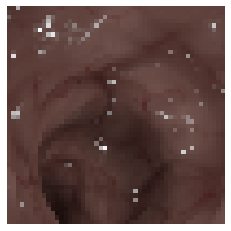

[1. 0.]


In [11]:
index = random.randint(0, 8814)
plt.axis("off")
plt.imshow(cv2.cvtColor(training_data[index][0], cv2.COLOR_BGR2RGB))
plt.show()
print(training_data[index][1])

In [12]:

X = torch.Tensor([i[0] for i in training_data]).view(-1, 3, IMG_SIZE, IMG_SIZE)
X = X/255.0
y = torch.Tensor([i[1] for i in training_data])

VAL_PCT = 0.1
val_size = int(len(X) * VAL_PCT)

train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]

C:\Users\Madhi\AppData\Local\Temp\ipykernel_1108\2368680580.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:204.)
  X = torch.Tensor([i[0] for i in training_data]).view(-1, 3, IMG_SIZE, IMG_SIZE)


In [13]:
class Net(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 5)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.conv3 = nn.Conv2d(64, 128, 5)
        
        x = torch.randn(IMG_SIZE,IMG_SIZE,3).view(-1, 3, IMG_SIZE, IMG_SIZE)
        
        self._to_linear = None
        self.convs(x)
        
        self.fc1 = nn.Linear(self._to_linear, 512)
        self.fc2 = nn.Linear(512, 2)
        
    def convs(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2,2))
        
        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
            
        return x
    
    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return F.softmax(x, dim = 1)
    
MODEL_NAME = f"model-{int(time.time())}"    
net = Net().to(device)
optimizer = optim.Adam(net.parameters(), lr = 0.001)
loss_function = nn.MSELoss()

In [15]:
def fwd_pass(X, y, train = False):
    if train:
        net.zero_grad()
    outputs = net(X)
    matches = [torch.argmax(i) == torch.argmax(j) for i, j in zip(outputs, y)]
    acc = matches.count(True)/len(matches)
    loss = loss_function(outputs, y)
    
    if train:
        loss.backward()
        optimizer.step()
    
    return acc, loss

def test(size=32):
    random_start = np.random.randint(len(test_X) - size)
    X, y = test_X[random_start:random_start+size], test_y[random_start:random_start+size]
    with torch.no_grad():
        val_acc, val_loss = fwd_pass(X.view(-1, 3, IMG_SIZE, IMG_SIZE).to(device), y.to(device))
    
    return val_acc, val_loss

def train():
    BATCH_SIZE = 100
    EPOCHS = 10
    with open("test.log", "a") as f:
        for epoch in range(EPOCHS):
            for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
                batch_X = train_X[i:i+BATCH_SIZE].view(-1, 3, IMG_SIZE, IMG_SIZE).to(device)
                batch_y = train_y[i:i+BATCH_SIZE].to(device)
                
                acc, loss = fwd_pass(batch_X, batch_y, train = True)
                if i % 50 == 0:
                    val_acc, val_loss = test(size = 100)
                    f.write(f"{MODEL_NAME},{round(time.time(),3)},{round(float(acc),2)},{round(float(loss),4)},{round(float(val_acc),2)},{round(float(val_loss),4)}\n")
        print(loss)
                    

In [16]:
train()

100%|██████████| 80/80 [00:01<00:00, 50.05it/s]

tensor(0.0038, device='cuda:0', grad_fn=<MseLossBackward0>)


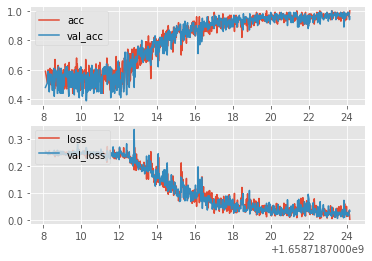

In [17]:
style.use("ggplot")
colnames=['Name', 'Time', 'Acc', 'Loss', "Val_Acc", "Val_Loss"] 
test = pd.read_csv("../scripts/test.log", names=colnames, header=None)

def create_acc_loss_graph():
    fig = plt.figure()
    ax1 = plt.subplot2grid((2,1), (0,0))
    ax2 = plt.subplot2grid((2,1), (1,0), sharex = ax1)
    
    ax1.plot(test['Time'], test['Acc'], label ="acc")
    ax1.plot(test['Time'], test['Val_Acc'], label ="val_acc")
    ax1.legend(loc=2)
    
    ax2.plot(test['Time'], test['Loss'], label = "loss")
    ax2.plot(test['Time'], test['Val_Loss'], label = "val_loss")
    ax2.legend(loc=2)
    
    plt.show()
    
create_acc_loss_graph()

Backup

In [ ]:
BATCH_SIZE = 100
EPOCHS = 10

for epoch in range(EPOCHS):
    for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
        batch_X = train_X[i:i+BATCH_SIZE].view(-1, 3, 50, 50).to(device)
        batch_y = train_y[i:i+BATCH_SIZE].to(device)
        
        net.zero_grad()
        outputs = net(batch_X)
        loss = loss_function(outputs, batch_y)
        loss.backward()
        optimizer.step()
    
    print(loss)
        


In [15]:
correct = 0
total = 0

with torch.no_grad():
    for i in tqdm(range(len(test_X))):
        real_class = torch.argmax(test_y[i]).to(device)
        net_out = net(test_X[i].view(-1, 3, 50, 50).to(device))[0]
        predicted_class = torch.argmax(net_out)
        
        if predicted_class == real_class:
            correct += 1
            
        total += 1
        
print("Accuracy: ", round(correct/total, 3))

100%|██████████| 881/881 [00:00<00:00, 1465.99it/s]

Accuracy:  0.97
